# Historical Omega Aragonite Velocity (RCP85 Ensemble Average)

In [2]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [3]:
%matplotlib inline

In [4]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Surface k01

In [5]:
# k01 Omega Arag for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Omega_Arag/RCP85/'
filename = 'omega_arag_k01_ensAvg_1950_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG': 'omega_arag'})

## Grid calculations

In [6]:
# default behavior is to extrapolite grid position to the left
ds_full = xgcm.generate_grid_ds(ds, {'X':'xt_ocean', 'Y':'yt_ocean'})

In [7]:
# Create grid object (periodic along X-axis)
grid = xgcm.Grid(ds_full, periodic=['X'], 
                 coords={'X': {'center': 'xt_ocean', 'left': 'xt_ocean_left'},
                         'Y': {'center': 'yt_ocean', 'left': 'yt_ocean_left'},
                         'T': {'center': 'time'}})

In [8]:
# Compute cartesian distances
grid_calculations(grid, ds_full)

---

## Historical 1950 to 2019 Omega Arag

In [9]:
# Calculate the time-mean Omega Arag for 1950-2019
ds_oa_annual = ds_full.omega_arag.groupby('time.year').mean(dim='time', skipna=True)
ds_oa_mean = ds_oa_annual.sel(year=1950).copy()
for yr in range(1951,2020):
     ds_oa_mean += ds_oa_annual.sel(year=yr)
        
ds_oa_mean = ds_oa_mean/70

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/common.py:671: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  return self._groupby_cls(
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Zonal Gradient of k01 Mean Omega Arag (ºC / km)

In [10]:
# Compute zonal (along x-axis) gradient of k01 Omega Arag
doa_dx = grid.diff(ds_oa_mean, 'X', boundary='fill', fill_value=np.nan) / (ds_full.dxg / 1000)
doa_dx = doa_dx.squeeze()

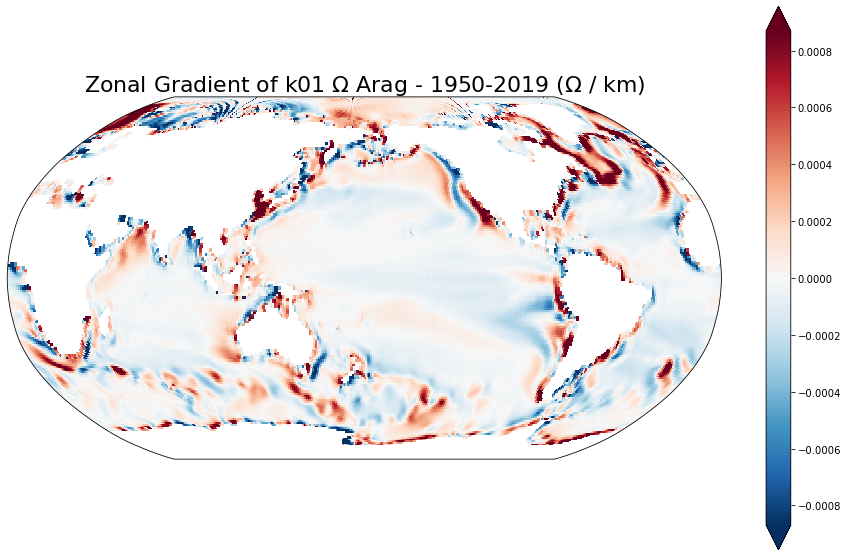

In [11]:
# Plot mean zonal Omega Arag gradient in 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

doa_dx.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Zonal Gradient of k01 $\Omega$ Arag - 1950-2019 ($\Omega$ / km)',
             fontsize=22)
ax.set_global() 
fig.savefig("oa_vel_historical")

## Meridional Gradient of k01 Omega Arag (ºC / km)

In [12]:
# Compute meridional (along y-axis) gradient of surface Omega Arag
doa_dy = grid.diff(ds_oa_mean, 'Y', boundary='fill', fill_value=np.nan) / (ds_full.dyg / 1000)
doa_dy = doa_dy.squeeze()

In [13]:
# Flip direction in southern hemisphere so directions are poleward
doa_dy[0:90] = -doa_dy[0:90]

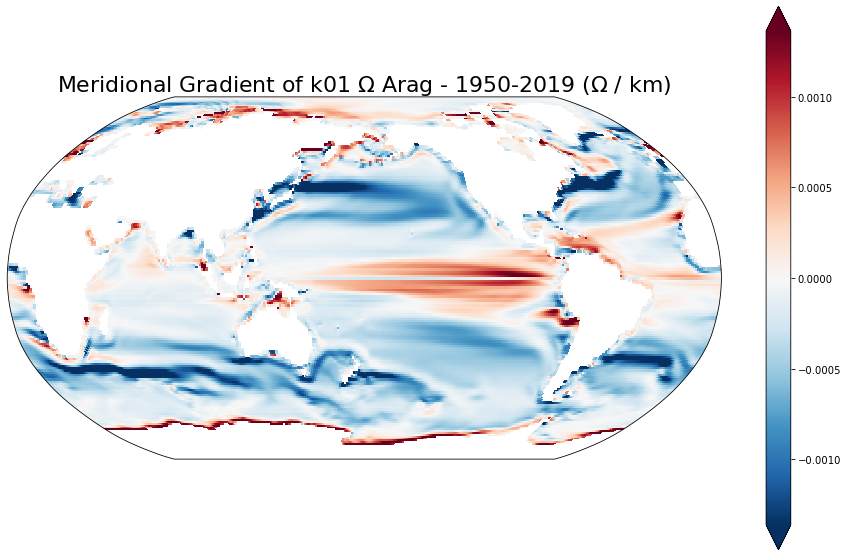

In [14]:
# Plot mean meridional Omega Arag gradient from 1950-2019
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

doa_dy.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Meridional Gradient of k01 $\Omega$ Arag - 1950-2019 ($\Omega$ / km)',
             fontsize=22)
ax.set_global()
fig.savefig("oa_vel_historical")

## Gradient Magnitude of k01 Omega Arag (ºC / km)

In [15]:
# Calculate magnitude of spatial gradient
dx2 = np.square(doa_dx).data
dy2 = np.square(doa_dy).data
doa_ds = np.sqrt(dx2+dy2)
# Create dataset
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data
doa_ds = xr.DataArray(doa_ds, dims=['yt_ocean','xt_ocean'], coords=[lat,lon])

In [16]:
# Create meshgrid for arrow plotting
X,Y = np.meshgrid(np.arange(360), np.arange(-90,90))
X = X+0.5
Y = Y+0.5
n=5

### Regular Plot

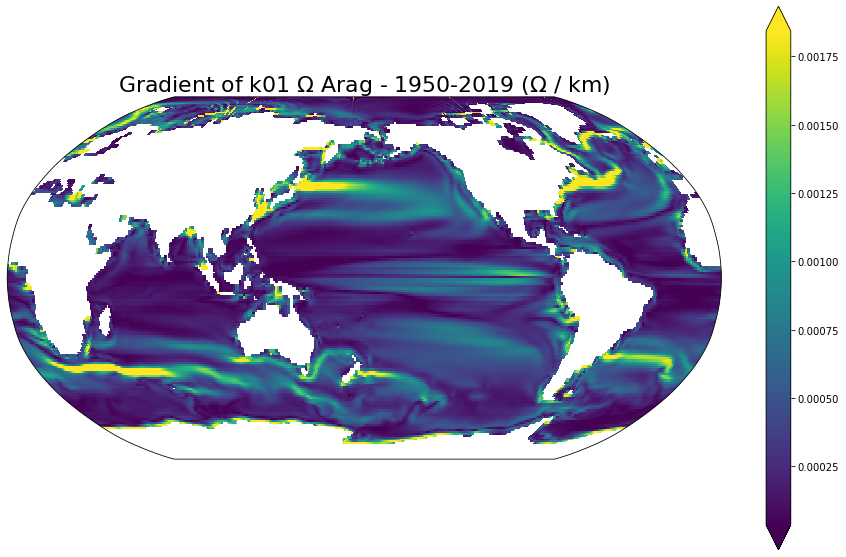

In [17]:
# Plot mean Omega Arag gradient from 1950-2019
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src=ccrs.PlateCarree()
doa_ds.plot(ax=ax, transform=src, robust=True)

ax.set_title('Gradient of k01 $\Omega$ Arag - 1950-2019 ($\Omega$ / km)',
             fontsize=22)

# # Normalize vectors to plot arrows of constant size
# U = doa_dx.data
# V = doa_dy.data
# N = np.sqrt(U**2 + V**2)
# U = U/N
# V = V/N

# # Plot arrows to show gradient direction
# ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
#            transform=src)
ax.set_global()
fig.savefig("oa_vel_historical")

### Latitudinal Mean Gradient

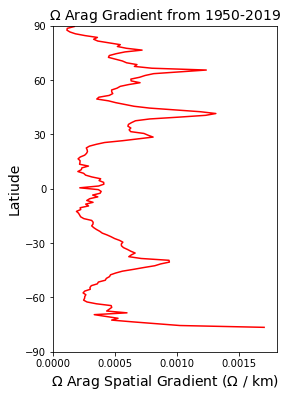

In [18]:
# Plot latitudinal mean zonal k01 omega aragonite gradient
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,6])
X = doa_ds.mean(dim='xt_ocean', skipna=True).squeeze()
Y = doa_ds['yt_ocean']

ax.plot(X,Y,'r')

ax.set_title('$\Omega$ Arag Gradient from 1950-2019',loc='center',fontsize=14)
# ax.autoscale(enable=True, axis='y', tight=True) # Make x-axis "tight"
ax.set_ylim(-90,90)
ax.set_xlim(X.min()-0.0001, X.max()+0.0001)
ax.set_yticks(np.arange(-90,91,30))
ax.set_xticks(np.arange(0,1.51e-3,5e-4))
ax.set_ylabel('Latiude',fontsize=14)
ax.set_xlabel('$\Omega$ Arag Spatial Gradient ($\Omega$ / km)',fontsize=14)


plt.show()

fig.savefig("temp_vel_stats")

### Contour Plot

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


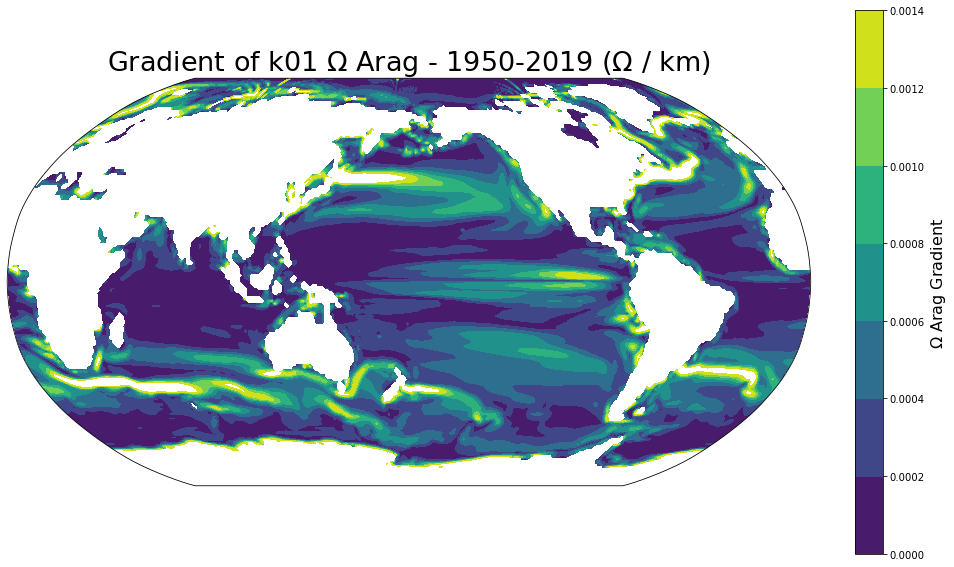

In [19]:
# Plot mean Omega Arag gradient from 1950-2019 -- Contour Plot
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src = ccrs.PlateCarree()
levels = np.arange(0, 1.5e-3, 2e-4)
im = ax.contourf(lon,lat,doa_ds,levels=levels, 
                 transform=src, robust=True)
cbar = plt.colorbar(im,ax=ax,orientation='vertical',fraction=0.05,pad=0.05)
cbar.set_label('$\Omega$ Arag Gradient', fontsize=16)
# ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

ax.set_title('Gradient of k01 $\Omega$ Arag - 1950-2019 ($\Omega$ / km)',
             fontsize=27)

ax.set_global()
fig.savefig("oa_vel_historical")

---

## k01 Omega Arag Change

### Decadal Omega Arag Change from 1950-2019 (ºC / decade)

#### Using Linear Regression (best model)

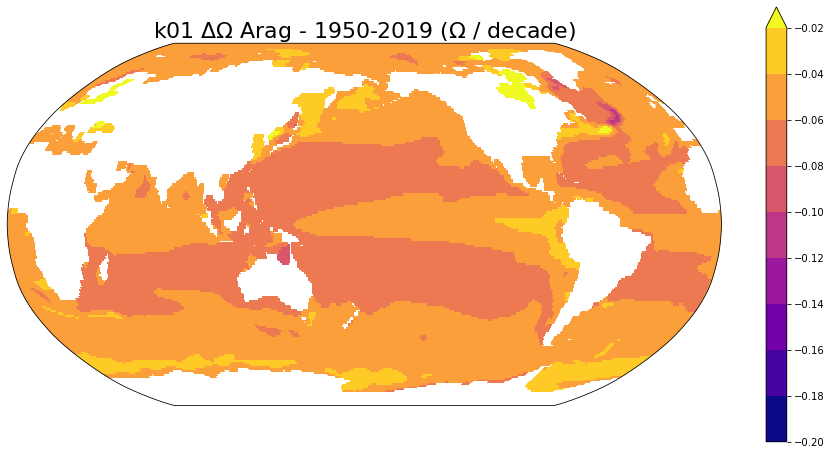

In [20]:
# Plot decadal Omega Arag change using best-fit linear model
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

# Get annual omega arag data for 1950-2019
ds_historical = ds_oa_annual.loc[1950:2019]

# Get lon, lat and time coordinates
lon = ds_historical.xt_ocean.data
lat = ds_historical.yt_ocean.data
years = ds_historical.year

# For each gridcell, obtain the linear regression for doa/dt
# using the annual means over the time period
nx = len(lon)
ny = len(lat)
da_bestfit = np.zeros(shape=(nx,ny))
for x in range(nx):
    for y in range(ny):
        # exclude NaN values
        cell = ds_historical.sel(xt_ocean=lon[x], yt_ocean=lat[y])
        idx = np.isfinite(cell).data.squeeze()
        yrs = years[idx].data.tolist()  # years with measured values
        pts = cell[idx].data.tolist()   # gridcells with measured values
        # calculate linear regression for omega arag (Y) vs. time (X)
        # (if there are at least 2 finite values)
        if sum(idx) > 1:
#             da_bestfit[x,y] = numba_leastsqr(yrs, pts)[0]
#             da_bestfit[x,y] = stats.linregress(pts)[0] * 10
            da_bestfit[x,y] = np.polyfit(yrs, pts, 1)[0] * 10
        else:
            da_bestfit[x,y] = np.nan
            
            
# Create DataArray and plot doa/dt for the decade
doa_dt = xr.DataArray(da_bestfit, dims=['xt_ocean','yt_ocean'], coords=[lon,lat])
clevs=np.arange(-0.2,-0.01,0.02)
doa_dt.T.plot(ax=ax, cmap='plasma', levels=clevs,
              transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 $\Delta$$\Omega$ Arag - 1950-2019 ($\Omega$ / decade)',
            fontsize=22)
ax.set_global()
fig.savefig("oa_vel_historical")

### Latitudinal Mean Omega Arag Change

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


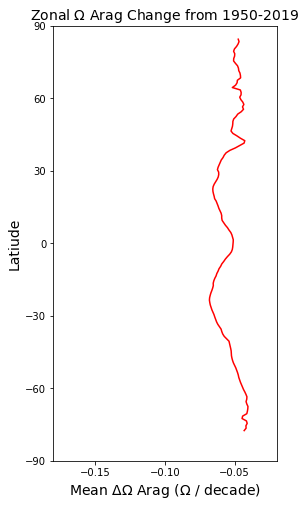

In [21]:
# plot latitudinal mean zonal k01 temperature change
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,8])
X = doa_dt.mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
Y = doa_dt['yt_ocean'][5:175]

ax.plot(X,Y,'r')

ax.set_title('Zonal $\Omega$ Arag Change from 1950-2019',loc='center',fontsize=14)
# ax.autoscale(enable=True, axis='y', tight=True) # Make x-axis "tight"
ax.set_ylim(-90,90)
ax.set_xlim(-0.18, -0.02)
ax.set_yticks(np.arange(-90,91,30))
ax.set_xticks(np.arange(-0.15,0,0.05))
ax.set_ylabel('Latiude',fontsize=14)
ax.set_xlabel('Mean $\Delta$$\Omega$ Arag ($\Omega$ / decade)',fontsize=14)


plt.show()

fig.savefig("temp_vel_stats")

---

## Zonal k01 Omega Arag Velocity (km/decade)

In [22]:
# Calculate zonal Omega Arag velocity
# Using linear regression over 1950-2019 for Omega Arag change over time,
# and time-mean decadal Omega Arag for spatial gradient
dOA_dt = doa_dt.squeeze().data
dOA_dx = doa_dx.squeeze().T.data
x_vel = dOA_dt/dOA_dx

# Create DataArray and plot Omega Arag velocity
x_vel = xr.DataArray(x_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
x_vel = x_vel.where(x_vel.loc[:,:] < np.inf)

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()
<ipython-input-22-7a45bd5ada6b>:6: RuntimeWarning: divide by zero encountered in true_divide
  x_vel = dOA_dt/dOA_dx


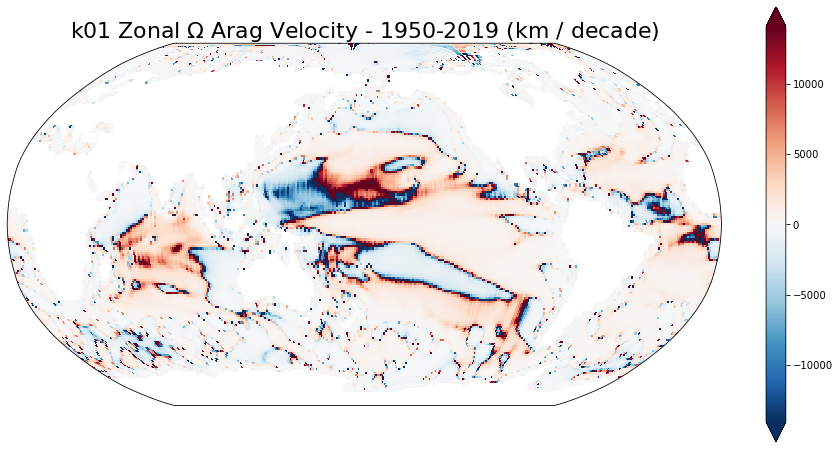

In [23]:
# Plot zonal Omega Arag Velocity (km/decade) from 1950-2019
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

x_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Zonal $\Omega$ Arag Velocity - 1950-2019 (km / decade)',
             fontsize=22)

fig.savefig("oa_vel_historical")

## Meridional Omega Arag Velocity (km/decade)

In [24]:
# Calculate meridional Omega Arag velocity
# Using linear regression over 1950-2019 for Omega Arag change over time,
# and time-mean decadal Omega Arag for spatial gradient
dOA_dt = doa_dt.squeeze().data
dOA_dy = doa_dy.squeeze().T.data
y_vel = dOA_dt/dOA_dy

# Create DataArray and plot Omega Arag velocity
y_vel = xr.DataArray(y_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
y_vel = y_vel.where(y_vel.loc[:,:] != np.inf)

<ipython-input-24-e759dcf12f26>:6: RuntimeWarning: divide by zero encountered in true_divide
  y_vel = dOA_dt/dOA_dy


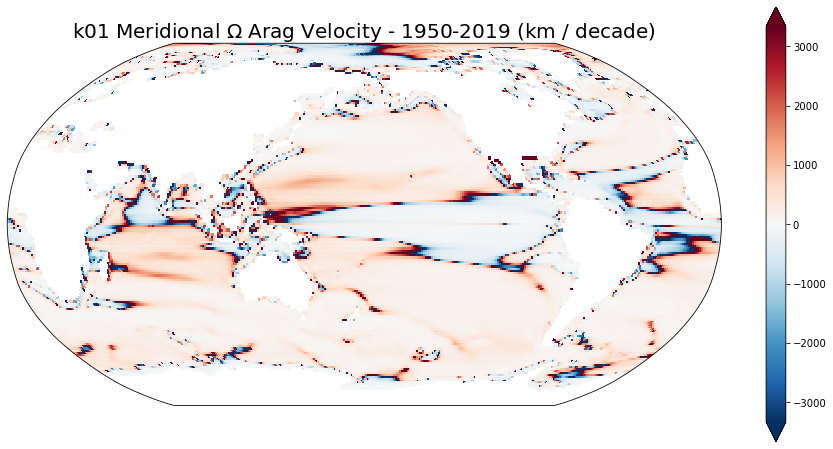

In [25]:
# Plot meridional omega arag velocity (km/decade) from 1950-2019
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

y_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Meridional $\Omega$ Arag Velocity - 1950-2019 (km / decade)',
             fontsize=20)

fig.savefig("oa_vel_historical")

## Omega Arag Velocity (km/decade)

In [26]:
# Calculate the magnitude for Omega Arag velocity 
dOA_dt = doa_dt.squeeze().data
dOA_ds = doa_ds.squeeze().T.data
velocity = abs(dOA_dt/dOA_ds)

# Create DataArray
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data

velocity = xr.DataArray(velocity, dims=['xt_ocean','yt_ocean'], 
                        coords=[lon,lat], name='velocity').T
velocity = velocity.where(velocity.loc[:,:] != np.inf)

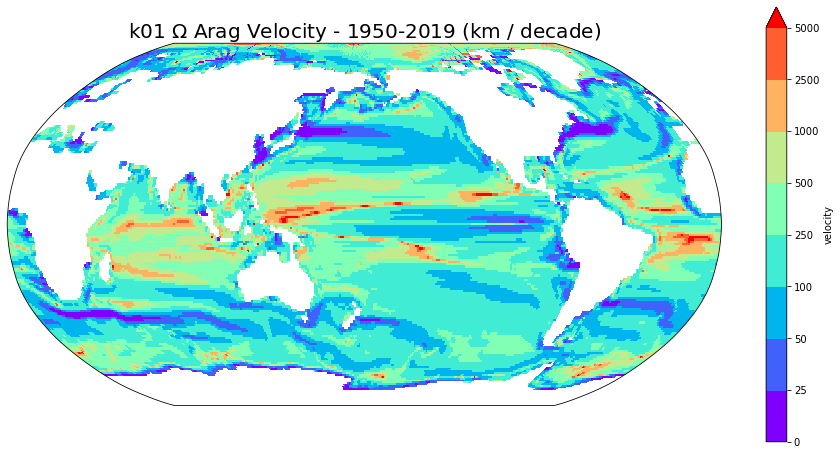

In [30]:
# Plot Omega Arag velocity magnitude (km/decade) from 1950-2019
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

# Create DataArray and plot Omega Arag velocity
clevs = [0,25,50,100,250,500,1000,2500,5000]
velocity.plot(ax=ax, levels=clevs, cmap='rainbow',
              transform=src, robust=True)
ax.set_title('k01 $\Omega$ Arag Velocity - 1950-2019 (km / decade)',
             fontsize=20)

# # Normalize vectors to plot arrows of constant size
# U = x_vel.data
# V = y_vel.data
# N = np.sqrt(U**2 + V**2)
# U = U/N
# V = V/N
# n=5

# # Plot arrows to show gradient direction
# ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
#            transform=src)

fig.savefig("oa_vel_historical")

### Latitudinal Mean Velocity

In [ ]:
# Plot latitudinal mean k01 omega arag velocity
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4,6])
X = velocity.mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
Y = velocity['yt_ocean'][5:175]

ax.plot(X,Y,'r')

ax.set_title('Zonal $\Omega$ Arag Velocity from 1950-2019',loc='center',fontsize=14)
# ax.autoscale(enable=True, axis='y', tight=True) # Make x-axis "tight"
ax.set_ylim(-90,90)
ax.set_xlim(0, 1500)
ax.set_yticks(np.arange(-90,91,30))
ax.set_ylabel('Latiude',fontsize=14)
ax.set_xlabel('Mean $\Omega$ Arag Velocity (km / decade)',fontsize=14)

plt.show()

fig.savefig("temp_vel_stats")

---